In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
def ryan_preprocess(df, poly):
    ma = df.as_matrix();
    m = df.shape[0];
    y = ma[:,-1:];
    X = ma[:,0:-1];
    X1 = X;
    X2 = X;
    
    for i in range(poly-1):
        X1 = X1*X2;
        X = np.append(X, X1, axis = 1);

    X = preprocessing.scale(X, axis=0);
    temp = np.ones(shape=(ma.shape[0], 1));
    X = np.append(temp, X, axis=1);

    return X, y, m, ma;

def ryan_split_data(data, val_ratio, test_ratio):
    rows = len(data);
    np.random.seed(1);
    shuffle = np.random.permutation(rows);
    val_size = int(rows*val_ratio/100);
    test_size = int(rows*test_ratio/100 + val_size);
    val_data = shuffle[:val_size];
    test_data = shuffle[val_size:test_size];
    train_data = shuffle[test_size:];
    return data.iloc[train_data], data.iloc[val_data], data.iloc[test_data];

def drawGraph(X, a, ma, df):
#     x = np.arange(0,10000,1);
#     y = np.zeros(10000);
#     for i in range(len(x)):
#         for j in range(a.shape[0]):
#             y[i] += a[j][0] * np.power(x[i], j);
    
    y_hat = np.dot(X, a);
    ma1 = np.append(ma[:,0:1], y_hat, axis=1);
    ma1 = ma1[ma1[:,0].argsort()];
    plt.plot(df['x'],df['y'],'b.', ma1[:,0], ma1[:,-1],'r-');
    plt.ylabel('y');
    plt.xlabel('x');
    plt.show();

def cost_func(a, X, y, m, lamb = None, reg = None):
#     t1 = np.dot(np.dot(np.dot(a.T, X.T), X), a);
#     t2 = np.dot(np.dot(2*y.T, X), a);
#     t3 = np.dot(y.T, y);
#     t4 = np.add(np.subtract(t1, t2), t3);
#     result = t4/m;
    
#     if(reg == 'ridge'):
# #         result += lamb/m * (np.sum((a*a)[1:]));
#         temp = a[0][0];
#         a[0][0] = 0;
# #         print(result, lamb/m * np.dot(a.T, a));
#         result += lamb/m * np.dot(a.T, a);
#         a[0][0]=temp;
# #     elif(reg == 'lasso'):
# #         result += lamb* np.absolute(a);
    
#     return result;

    return mean_squared_error(np.dot(X, a), y);

def updateMatrix(alpha, a, X, y, m, lamb = None, reg = None):
    t1 = np.dot(np.dot(X.T, X), a);
    t2 = np.dot(X.T, y);
    temp = 2*alpha/m * np.subtract(t1, t2);
    
    a1 = np.zeros(shape=(a.shape[0],1));
    if(reg == 'ridge'):
        a0 = a[0][0];
        a[0][0] = 0;
        a1 = (2*lamb*alpha/m) * a;
        a[0][0] = a0;
        
    a = np.subtract(a, np.add(temp, a1));
    return a;

def ryan_gradientDescent(thresh, alpha, X, y, m, X_val = None, y_val = None, m_val = None, lamb = None, reg = None):
    last_cost_train = float('inf');
    a_min_train = np.ones(shape=(X.shape[1], 1));
    last_alpha_train = 0.0;
    last_cost_val = float('inf');
    a_min_val = np.ones(shape=(X.shape[1], 1));
    last_alpha_val = 0.0;
    for i in range(len(alpha)):
        a = np.ones(shape=(X.shape[1], 1));
        prevCost = cost_func(a, X, y, m, lamb, reg);
        cc = 0;
        while True:
            a = updateMatrix(alpha[i], a, X, y, m, lamb, reg);
            cost = cost_func(a, X, y, m, lamb, reg);
            if cc >= 10000 or abs(prevCost - cost) <= thresh: break;
            prevCost = cost;
            cc+=1
        
        if(cost_func(a, X, y, m, lamb, reg) <= last_cost_train):
            last_cost_train = cost_func(a, X, y, m, lamb, reg);
            a_min_train = a;
            last_alpha_train = alpha[i];
            
        if(X_val != None and cost_func(a, X_val, y_val, m_val, lamb, reg) <= last_cost_val):
            last_cost_val = cost_func(a, X_val, y_val, m_val, lamb, reg);
            a_min_val = a;
            last_alpha_val = alpha[i];
            

    return a_min_train, last_cost_train, last_alpha_train, a_min_val, last_cost_val, last_alpha_val;

## tensor
def draw_w_coef(w_arr, lamb_arr, poly):
    colors = ['C0-', 'C1-', 'C2-', 'C3-', 'C4-', 'C5-', 'C6-', 'C7-', 'C8-'];

    for i in range(len(w_arr)-1):
        w_arr[0] = np.append(w_arr[0], w_arr[i+1], axis = 1);
    
    if poly == False:
        for i in range(w_arr[0].shape[0]):
            plt.plot(lamb_arr, w_arr[0][i,:], colors[i]);
    else:
        plt.plot(lamb_arr, w_arr[0][1], colors[1]);
    plt.ylabel('coefficients');
    plt.xlabel('lambda');
    plt.show();
    
def ryan_tensorflow(lamb, X, y, X_val, y_val, reg):
    w_arr = [];
    
    min_rmse = float('inf');
    min_weights = float('inf');
    min_lamb = 0.0;
    m = X.shape[0];
    
    min_rmse_val = float('inf');
    min_weights_val = float('inf');
    min_lamb_val = 0.0;
    m_val = X_val.shape[0];
    
    learning_rate = 0.001;
    for i in range(len(lamb)):
        tf.reset_default_graph();
        W = tf.Variable(tf.zeros([9,1]));
        X1 = X.astype(np.float32);
        y1 = y.astype(np.float32);
        X1_val = X_val.astype(np.float32);
        y1_val = y_val.astype(np.float32);
        pred = tf.matmul(X1, W);
        pred_val = tf.matmul(X1_val, W);
        rmse = tf.sqrt(tf.reduce_mean(tf.square(pred - y1)));
        rmse_val = tf.sqrt(tf.reduce_mean(tf.square(pred_val - y1_val)));
        base_loss = tf.reduce_mean(tf.square(pred - y1));
        reg_loss = tf.reduce_sum(tf.square(W));
        loss = tf.add(base_loss, lamb[i]/m * reg_loss);
        
        if(reg == 'ridge'):
            gradients = 2/m * tf.add(tf.matmul(tf.transpose(X1), pred - y1), lamb[i] * W);
        elif(reg == 'lasso'):
            gradients = 2/m * tf.add(tf.matmul(tf.transpose(X1), pred - y1), lamb[i] * (2 * tf.sigmoid(50*W) - 1));
        else: print('you need to specify regularization');
        
        training_op = tf.assign(W, W - learning_rate * gradients);
        init = tf.global_variables_initializer();

        with tf.Session() as sess:
            sess.run(init);
            for _ in range(5000):
                sess.run(gradients);
                sess.run(training_op);
                
            temp_rmse = sess.run(rmse);
            temp_w = sess.run(W);
            temp_rmse_val = sess.run(rmse_val);
            
            w_arr.append(temp_w);
            
            if(temp_rmse <= min_rmse):
                min_rmse = temp_rmse;
                min_weights = temp_w;
                min_lamb = lamb[i];

            if(temp_rmse_val <= min_rmse_val):
                min_rmse_val = temp_rmse_val;
                min_weights_val = temp_w;
                min_lamb_val = lamb[i];
            
    return min_weights, min_rmse, min_lamb, min_weights_val, min_rmse_val, min_lamb_val, w_arr;

### 1-1

In [3]:
df = pd.read_csv('ex2data1.csv.xls');
df.head()

,x,y
0,0.259901,1.291599
1,0.645010,1.015651
2,0.041568,0.187619
3,0.646758,0.271723
4,0.904388,-0.822251


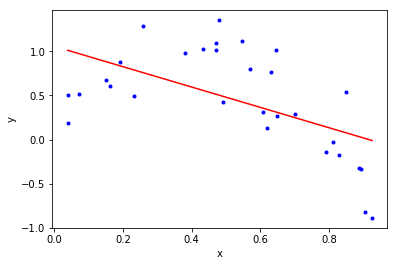

Learning rate:  0.05
Weights:
 [[ 1.05728188]
 [-1.15543266]]
RMSE:  0.47632904965746153


In [4]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, ma[:,0:-1], axis=1);

## Train
alpha = [0.01, 0.05, 0.001];
a_train, cost_train, alpha_train,_,_,_ = ryan_gradientDescent(0.000001, alpha, X, y, m);

## Draw + print rmse
drawGraph(X, a_train, ma, df);
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

### 1-2

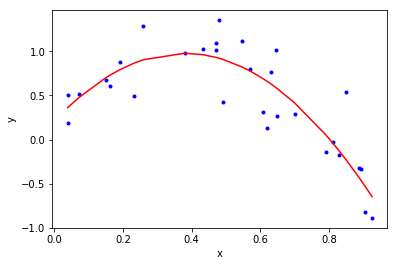

Learning rate:  0.05
Weights:
 [[ 0.45269151]
 [ 1.12191972]
 [-1.49692391]]
RMSE:  0.2857262014539427


In [5]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
X = ma[:,0:-1];
X = np.append(X, X*X, axis = 1);
X = preprocessing.scale(X, axis=0);
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, X, axis = 1);

## Train
alpha = [0.01, 0.05, 0.001];
a_train, cost_train, alpha_train,_,_,_ = ryan_gradientDescent(0.0000001, alpha, X, y, m);

## Draw + print rmse
drawGraph(X, a_train, ma, df);
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

### 1-3

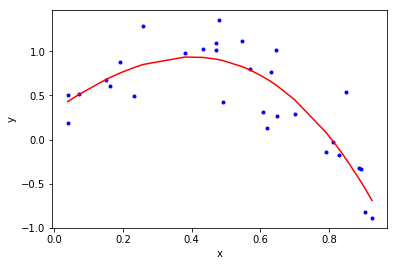

Learning rate:  0.05
Weights:
 [[ 0.45269151]
 [ 0.74913437]
 [-0.60333527]
 [-0.50842831]
 [-0.03175693]]
RMSE:  0.28912385768783777


In [6]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
X = ma[:,0:-1];
X1 = X;
X2 = X;
for i in range(3):
    X1 = X1*X2;
    X = np.append(X, X1, axis = 1);
    
X = preprocessing.scale(X, axis=0);
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, X, axis = 1);

## Train
alpha = [0.01, 0.05, 0.001];
a_train, cost_train, alpha_train,_,_,_ = ryan_gradientDescent(0.000001, alpha, X, y, m);

## Draw + print rmse
drawGraph(X, a_train, ma, df);
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

### 1-4

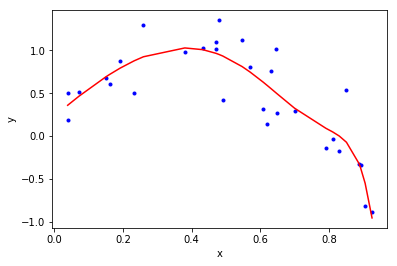

Learning rate:  0.05
Weights:
 [[ 0.45269151]
 [ 0.95555034]
 [-0.55974378]
 [-0.79610363]
 [-0.56419756]
 [-0.23534035]
 [ 0.05078719]
 [ 0.25166848]
 [ 0.36324996]
 [ 0.39556358]
 [ 0.36264336]
 [ 0.27844883]
 [ 0.1553641 ]
 [ 0.00380417]
 [-0.16772038]
 [-0.35237123]
 [-0.54471163]]
RMSE:  0.26480019560656715


In [7]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
X = ma[:,0:-1];
X1 = X;
X2 = X;

for i in range(15):
    X1 = X1*X2;
    X = np.append(X, X1, axis = 1);

X = preprocessing.scale(X, axis=0);
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, X, axis = 1);

## Train
alpha = [0.01, 0.05, 0.001];
a_train, cost_train, alpha_train,_,_,_ = ryan_gradientDescent(0.000001, alpha, X, y, m);

## Draw + print rmse
drawGraph(X, a_train, ma, df);
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

### 1-5

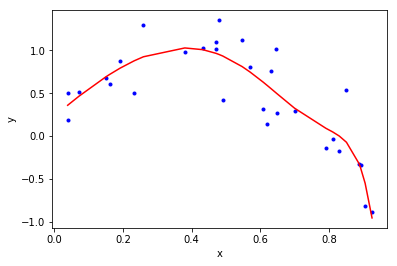

Learning rate:  0.05
Lambda:  0.0001
Weights:
 [[ 0.45269151]
 [ 0.95539241]
 [-0.5596219 ]
 [-0.7959631 ]
 [-0.56411632]
 [-0.23532592]
 [ 0.05074947]
 [ 0.25159797]
 [ 0.36316465]
 [ 0.39547836]
 [ 0.36256981]
 [ 0.27839561]
 [ 0.15533745]
 [ 0.00380843]
 [-0.16768238]
 [-0.3522978 ]
 [-0.54460193]]
RMSE:  0.26480299231699095


In [8]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
X = ma[:,0:-1];
X1 = X;
X2 = X;

for i in range(15):
    X1 = X1*X2;
    X = np.append(X, X1, axis = 1);

X = preprocessing.scale(X, axis=0);
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, X, axis = 1);

## Train
alpha = [0.01, 0.05, 0.001];
lamb = [0.001, 0.003, 0.0001];
a_min = np.ones(shape = (X.shape[1], 1));
cost_min = float('inf');
alpha_min = 0.0;
for i in range(len(lamb)):
    a_train, cost_train, alpha_train,_,_,_ = ryan_gradientDescent(0.000001, alpha, X, y, m, None, None, None, lamb[i], 'ridge');
    if cost_train <= cost_min:
        a_min = a_train;
        cost_min = cost_train;
        alpha_min = alpha_train;
        lamb_min = lamb[i];

## Draw + print rmse
drawGraph(X, a_min, ma, df);
print('Learning rate: ', alpha_min);
print('Lambda: ', lamb_min);
print('Weights:\n', a_min);
print('RMSE: ', math.sqrt(cost_min));

### 1-6

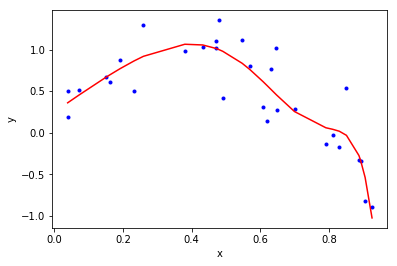

[[ 0.45269151]
 [ 0.78742277]
 [-0.01258937]
 [-0.67285702]
 [-0.89205417]
 [-0.95616895]
 [-0.68653987]
 [ 0.00678401]
 [ 0.86836292]
 [ 1.49614163]
 [ 1.5828353 ]
 [ 1.04479622]
 [ 0.04639246]
 [-1.03543339]
 [-1.67044964]
 [-1.23727938]
 [ 0.92164774]]
RMSE:  0.2623802312679255


In [9]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
X = ma[:,0:-1];
X1 = X;

for i in range(15):
    X1 = X1*X2;
    X = np.append(X, X1, axis = 1);

X = preprocessing.scale(X, axis=0);
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, X, axis = 1);

## Train
lamb = [0.001, 0.003, 0.0001];
a_min = np.ones(shape = (X.shape[1], 1));
w0 = 0;
cost_min = float('inf');
for i in range(len(lamb)):
    clf = Ridge(alpha=lamb[i]);
    clf.fit(X,y);
    a_temp = clf.coef_.T;
    cost = mean_squared_error(clf.predict(X), y) + lamb[i]/m * (np.sum((a_temp**2)[1:]));
    if cost <= cost_min:
        a_min = clf.coef_.T;
        w0 = clf.intercept_[0];
        cost_min = cost;

a_min[0][0] = w0;

## Draw + print rmse
drawGraph(X, a_min, ma, df);
print(a_min);
print('RMSE: ', math.sqrt(cost_min));

### 1-7

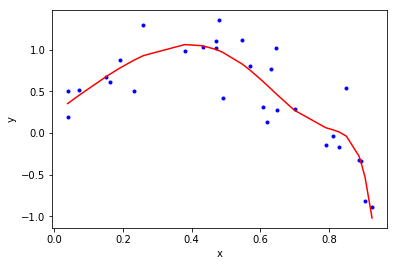

[[ 0.45269151]
 [ 0.83100475]
 [-0.        ]
 [-0.94464181]
 [-1.37223479]
 [-0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 2.2616591 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.        ]
 [-0.        ]
 [-1.1833329 ]]
RMSE:  0.2625516930689541


In [10]:
## preprocess, init variables
ma = df.as_matrix();
m = df.shape[0];
y = ma[:,-1:];
X = ma[:,0:-1];
X1 = X;

for i in range(15):
    X1 = X1*X2;
    X = np.append(X, X1, axis = 1);

X = preprocessing.scale(X, axis=0);
temp = np.ones(shape=(ma.shape[0], 1));
X = np.append(temp, X, axis = 1);

## Train
lamb = [0.001, 0.003, 0.0001];
a_min = np.ones(shape = (X.shape[1], 1));
w0 = 0;
cost_min = float('inf');
for i in range(len(lamb)):
    clf = Lasso(alpha=lamb[i], max_iter=1000000);
    clf.fit(X,y);
    a = clf.coef_.reshape(len(clf.coef_), 1);
    cost = mean_squared_error(clf.predict(X), y);
    if cost <= cost_min:
        a_min = a;
        w0 = clf.intercept_[0];
        cost_min = cost;

a_min[0][0] = w0;

## Draw + print rmse
drawGraph(X, a_min, ma, df);
print(a_min);
print('RMSE: ', math.sqrt(cost_min));

### 2-1

In [11]:
df = pd.read_csv('ex2data2.csv.xls');
df.columns = ['x', 'y'];
df.head()

,x,y
0,430,80000.0
1,460,247000.0
2,470,192500.0
3,490,150000.0
4,500,125000.0


In [12]:
df_train, df_val, df_test = ryan_split_data(df, 20, 20);

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/ipykernel_launcher.py:104: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


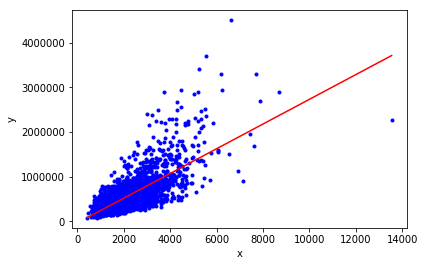

Train data
Learning rate:  0.05
Weights:
 [[ 549223.94828657]
 [ 269058.40779281]]
RMSE:  260409.2063659123


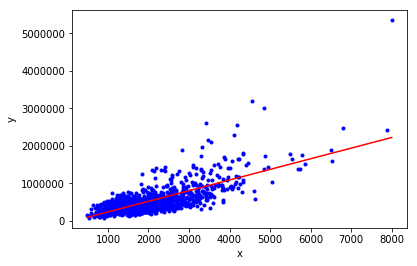

Validation data
Learning rate:  0.001
Weights:
 [[ 549223.89517311]
 [ 269058.38177319]]
RMSE:  264305.74619343725


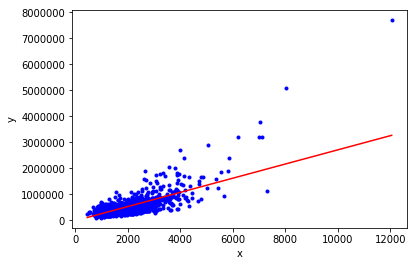

Test data
Learning rate:  0.001
Weights:
 [[ 549223.89517311]
 [ 269058.38177319]]
RMSE:  296556.47840036557


In [13]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 0);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 0);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 0);

# Train
alpha = [0.01, 0.05, 0.001];
a_train, cost_train, alpha_train, a_val, cost_val, alpha_val = ryan_gradientDescent(0.000001, alpha, X_train, y_train, m_train, X_val, y_val, m_val);

# Draw + print rmse
drawGraph(X_train, a_train, ma_train, df_train);
print('Train data');
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

drawGraph(X_val, a_val, ma_val, df_val);
print('Validation data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_val));

drawGraph(X_test, a_val, ma_test, df_test);
print('Test data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_func(a_val, X_test, y_test, m_test, None, None))); 


### 2-2

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/ipykernel_launcher.py:104: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


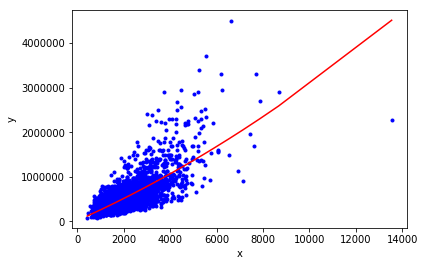

Train data
Learning rate:  0.05
Weights:
 [[ 549223.95314427]
 [ 226560.27169883]
 [  46525.62208433]]
RMSE:  259719.8751267522


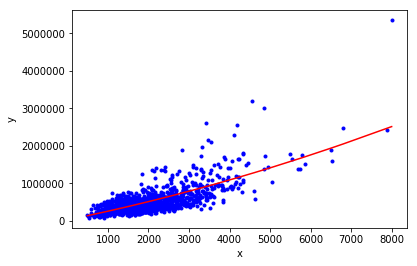

Validation data
Learning rate:  0.001
Weights:
 [[ 549223.9520369 ]
 [ 210627.52684467]
 [  62458.3669385 ]]
RMSE:  258412.07587247272


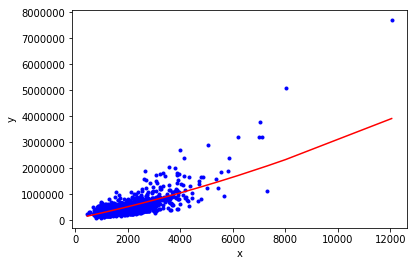

Test data
Learning rate:  0.001
Weights:
 [[ 549223.9520369 ]
 [ 210627.52684467]
 [  62458.3669385 ]]
RMSE:  283148.7910225275


In [14]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 2);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 2);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 2);

## Train
alpha = [0.01, 0.05, 0.001];
a_train, cost_train, alpha_train, a_val, cost_val, alpha_val = ryan_gradientDescent(0.000001, alpha, X_train, y_train, m_train, X_val, y_val, m_val);

## Draw + print rmse
drawGraph(X_train, a_train, ma_train, df_train);
print('Train data');
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

drawGraph(X_val, a_val, ma_val, df_val);
print('Validation data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_val));

drawGraph(X_test, a_val, ma_test, df_test);
print('Test data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_func(a_val, X_test, y_test, m_test, None, None))); 


### 2-3

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/ipykernel_launcher.py:104: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


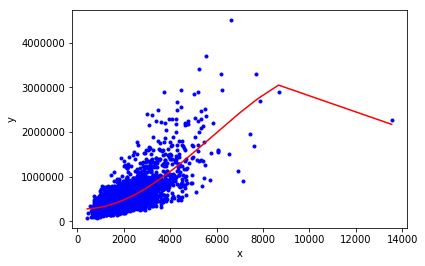

Train data
Learning rate:  0.08
Weights:
 [[ 549223.95314427]
 [ -36985.34180362]
 [ 472449.97649203]
 [-135674.28831592]
 [ -91360.09415373]]
RMSE:  250921.59717640345


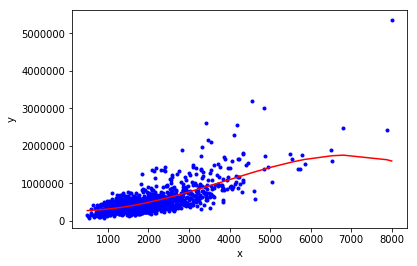

Validation data
Learning rate:  0.08
Weights:
 [[ 549223.95314427]
 [ -36985.34180362]
 [ 472449.97649203]
 [-135674.28831592]
 [ -91360.09415373]]
RMSE:  267463.5390959547


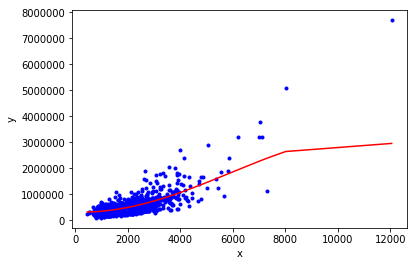

Test data
Learning rate:  0.08
Weights:
 [[ 549223.95314427]
 [ -36985.34180362]
 [ 472449.97649203]
 [-135674.28831592]
 [ -91360.09415373]]
RMSE:  286916.4111622897


In [15]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 4);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 4);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 4);

## Train
alpha = [0.01, 0.03, 0.08];
a_train, cost_train, alpha_train, a_val, cost_val, alpha_val = ryan_gradientDescent(1000, alpha, X_train, y_train, m_train, X_val, y_val, m_val);

## Draw + print rmse
drawGraph(X_train, a_train, ma_train, df_train);
print('Train data');
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

drawGraph(X_val, a_val, ma_val, df_val);
print('Validation data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_val));

drawGraph(X_test, a_val, ma_test, df_test);
print('Test data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_func(a_val, X_test, y_test, m_test, None, None))); 


### 2-4

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/ipykernel_launcher.py:104: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


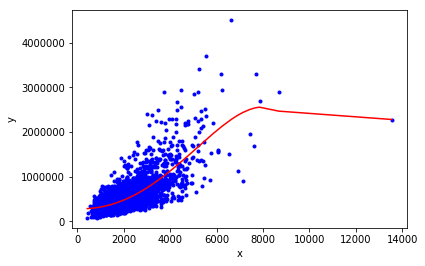

Train data
Learning rate:  0.05
Weights:
 [[ 549223.95314427]
 [ -19667.53648992]
 [ 354462.68809519]
 [ 109156.68885763]
 [-155523.57301452]
 [-188430.45950441]
 [-127368.42629624]
 [ -60868.42949084]
 [ -13291.11451828]
 [  15523.43207528]
 [  31281.30684634]
 [  39186.7073022 ]
 [  42774.79132446]
 [  44158.44106981]
 [  44503.87888618]
 [  44414.59301917]
 [  44182.54821699]]
RMSE:  250524.8554722922


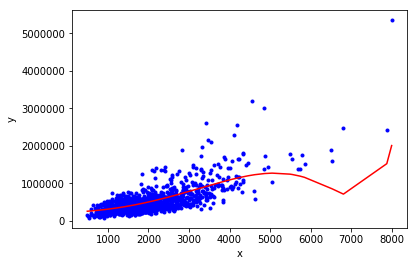

Validation data
Learning rate:  0.01
Weights:
 [[ 549223.95314426]
 [  25003.58414935]
 [ 290855.05709365]
 [  93179.94292429]
 [-105415.9752991 ]
 [-137395.35851508]
 [-100386.07421609]
 [ -55496.37870821]
 [ -20729.4565823 ]
 [   2489.61046179]
 [  16958.85421867]
 [  25647.96191776]
 [  30758.0388162 ]
 [  33728.03077596]
 [  35443.56391968]
 [  36432.05331094]
 [  37001.69052145]]
RMSE:  273238.8348124516


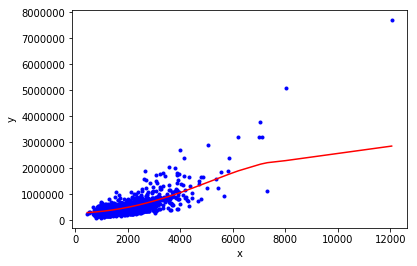

Test data
Learning rate:  0.01
Weights:
 [[ 549223.95314426]
 [  25003.58414935]
 [ 290855.05709365]
 [  93179.94292429]
 [-105415.9752991 ]
 [-137395.35851508]
 [-100386.07421609]
 [ -55496.37870821]
 [ -20729.4565823 ]
 [   2489.61046179]
 [  16958.85421867]
 [  25647.96191776]
 [  30758.0388162 ]
 [  33728.03077596]
 [  35443.56391968]
 [  36432.05331094]
 [  37001.69052145]]
RMSE:  292660.06314569747


In [16]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 16);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 16);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 16);

## Train
alpha = [0.01, 0.03, 0.05];
a_train, cost_train, alpha_train, a_val, cost_val, alpha_val = ryan_gradientDescent(1000, alpha, X_train, y_train, m_train, X_val, y_val, m_val);

## Draw + print rmse 
drawGraph(X_train, a_train, ma_train, df_train);
print('Train data');
print('Learning rate: ', alpha_train);
print('Weights:\n', a_train);
print('RMSE: ', math.sqrt(cost_train));

drawGraph(X_val, a_val, ma_val, df_val);
print('Validation data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_val));

drawGraph(X_test, a_val, ma_test, df_test);
print('Test data');
print('Learning rate: ', alpha_val);
print('Weights:\n', a_val);
print('RMSE: ', math.sqrt(cost_func(a_val, X_test, y_test, m_test, None, None))); 


### 2-5

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/ipykernel_launcher.py:104: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


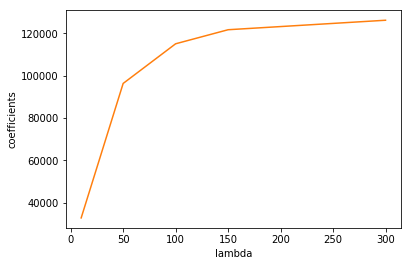

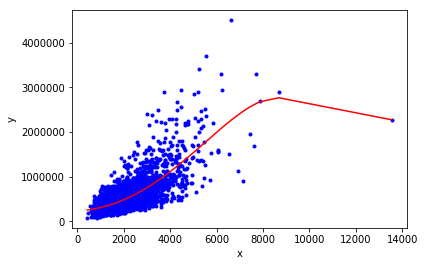

Train data
Learning rate:  0.05
Lambda:  10
Weights:
 [[ 549223.95314427]
 [  32924.69324953]
 [ 278848.9220183 ]
 [  91272.39192468]
 [ -99352.84122683]
 [-128901.34566239]
 [ -92228.17507823]
 [ -49107.05190467]
 [ -16718.69396055]
 [   4078.63591178]
 [  16403.0603773 ]
 [  23349.31055025]
 [  27123.24606433]
 [  29110.46746783]
 [  30124.85232887]
 [  30624.48295475]
 [  30859.23795724]]
RMSE:  250787.43477432488


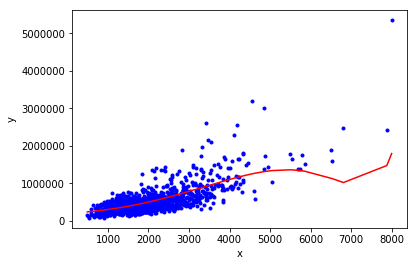

Validation data
Learning rate:  0.01
Lambda:  10
Weights:
 [[  5.49223953e+05]
 [  4.99972909e+04]
 [  2.54570099e+05]
 [  8.52747795e+04]
 [ -8.06831854e+04]
 [ -1.09565300e+05]
 [ -8.15241523e+04]
 [ -4.63544000e+04]
 [ -1.88534136e+04]
 [ -3.70575975e+02]
 [  1.12148531e+04]
 [  1.82151726e+04]
 [  2.23599399e+04]
 [  2.47868707e+04]
 [  2.62001948e+04]
 [  2.70217897e+04]
 [  2.74997652e+04]]
RMSE:  276174.5124534645


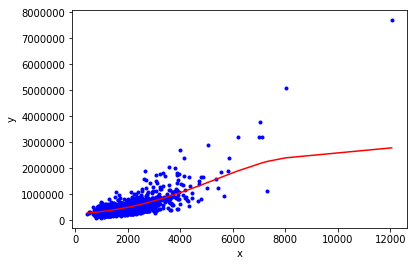

Test data
Learning rate:  0.01
Lambda:  10
Weights:
 [[  5.49223953e+05]
 [  4.99972909e+04]
 [  2.54570099e+05]
 [  8.52747795e+04]
 [ -8.06831854e+04]
 [ -1.09565300e+05]
 [ -8.15241523e+04]
 [ -4.63544000e+04]
 [ -1.88534136e+04]
 [ -3.70575975e+02]
 [  1.12148531e+04]
 [  1.82151726e+04]
 [  2.23599399e+04]
 [  2.47868707e+04]
 [  2.62001948e+04]
 [  2.70217897e+04]
 [  2.74997652e+04]]
RMSE:  292674.2511526881


In [17]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 16);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 16);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 16);
w_arr = [];
## Train
alpha = [0.01, 0.03, 0.05];
lamb = [10, 50, 100, 150, 300];

a_min_train = np.ones(shape = (X_train.shape[1], 1));
cost_min_train = float('inf');
alpha_min_train = 0.0;
lamb_min_train = 0.0;
a_min_val = np.ones(shape = (X_val.shape[1], 1));
cost_min_val = float('inf');
alpha_min_val = 0.0;
lamb_min_val = 0.0;
for i in range(len(lamb)):
    a_train, cost_train, alpha_train, a_val, cost_val, alpha_val = ryan_gradientDescent(100, alpha, X_train, y_train, m_train, X_val, y_val, m_val, lamb[i], 'ridge');
    w_arr.append(a_train);
    
    if cost_train <= cost_min_train:
        a_min_train = a_train;
        cost_min_train = cost_train;
        alpha_min_train = alpha_train;
        lamb_min_train = lamb[i];
    
    if cost_val <= cost_min_val:
        a_min_val = a_val;
        cost_min_val = cost_val;
        alpha_min_val = alpha_val;
        lamb_min_val = lamb[i];
        
## Draw + print rmse
draw_w_coef(w_arr, lamb, True);
drawGraph(X_train, a_min_train, ma_train, df_train);
print('Train data');
print('Learning rate: ', alpha_min_train);
print('Lambda: ', lamb_min_train);
print('Weights:\n', a_min_train);
print('RMSE: ', math.sqrt(cost_min_train));

drawGraph(X_val, a_min_val, ma_val, df_val);
print('Validation data');
print('Learning rate: ', alpha_min_val);
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_val));

drawGraph(X_test, a_min_val, ma_test, df_test);
print('Test data');
print('Learning rate: ', alpha_min_val);
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_func(a_min_val, X_test, y_test, m_test, lamb_min_val, 'ridge')));

### 2-6

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


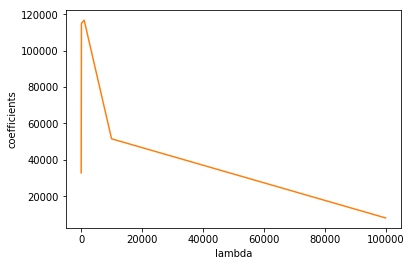

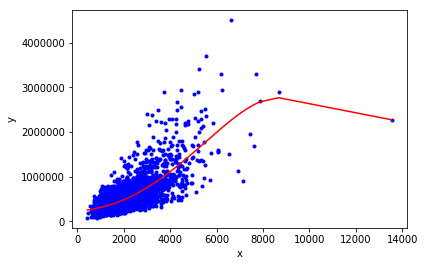

Train data
Lambda:  10
Weights:
 [[ 549223.95314427]
 [  32862.41747905]
 [ 278928.53110371]
 [  91430.13219908]
 [ -99729.20719956]
 [-129134.04981192]
 [ -92072.74779797]
 [ -48705.89389995]
 [ -16273.10851582]
 [   4435.63009976]
 [  16614.71618872]
 [  23409.10315926]
 [  27049.48195528]
 [  28929.72897998]
 [  29863.31114086]
 [  30304.2920832 ]
 [  30497.67196325]]
RMSE:  250787.04366929183


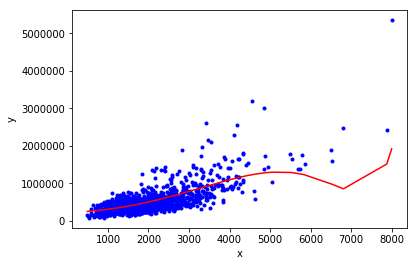

Validation data
Lambda:  10
Weights:
 [[ 549223.95314427]
 [  32862.41747905]
 [ 278928.53110371]
 [  91430.13219908]
 [ -99729.20719956]
 [-129134.04981192]
 [ -92072.74779797]
 [ -48705.89389995]
 [ -16273.10851582]
 [   4435.63009976]
 [  16614.71618872]
 [  23409.10315926]
 [  27049.48195528]
 [  28929.72897998]
 [  29863.31114086]
 [  30304.2920832 ]
 [  30497.67196325]]
RMSE:  272104.7309841629


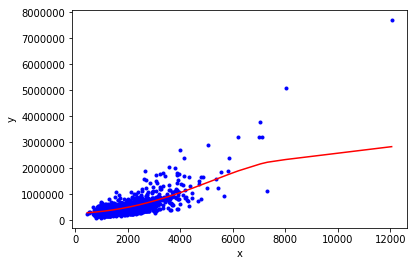

Test data
Lambda:  10
Weights:
 [[ 549223.95314427]
 [  32862.41747905]
 [ 278928.53110371]
 [  91430.13219908]
 [ -99729.20719956]
 [-129134.04981192]
 [ -92072.74779797]
 [ -48705.89389995]
 [ -16273.10851582]
 [   4435.63009976]
 [  16614.71618872]
 [  23409.10315926]
 [  27049.48195528]
 [  28929.72897998]
 [  29863.31114086]
 [  30304.2920832 ]
 [  30497.67196325]]
RMSE:  292617.156346377


In [18]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 16);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 16);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 16);
w_arr = [];
## Train
lamb = [10, 100, 1000, 10000, 100000];
a_min_train = np.ones(shape = (X_train.shape[1], 1));
cost_min_train = float('inf');
lamb_min_train = 0.0;
a_min_val = np.ones(shape = (X_val.shape[1], 1));
cost_min_val = float('inf');
lamb_min_val = 0.0;
w0_train = 0;
w0_val = 0;

for i in range(len(lamb)):
    clf = Ridge(alpha=lamb[i]);
    clf.fit(X_train, y_train);
    a_temp = clf.coef_.T;
    
    a_temp = clf.coef_.T;
    a_temp1 = a_temp;
    a_temp1[0][0] = clf.intercept_[0];
    w_arr.append(a_temp1);
    
    cost_train = mean_squared_error(np.dot(X_train, a_temp1), y_train);
    cost_val = mean_squared_error(np.dot(X_val, a_temp1), y_val);

    if cost_train <= cost_min_train:
        a_min_train = clf.coef_.T;
        w0_train = clf.intercept_[0];
        cost_min_train = cost_train;
        lamb_min_train = lamb[i];

    if cost_val <= cost_min_val:
        a_min_val = clf.coef_.T;
        w0_val = clf.intercept_[0];
        cost_min_val = cost_val;
        lamb_min_val = lamb[i];
        
a_min_train[0][0] = w0_train;
a_min_val[0][0] = w0_val;

## Draw + print rmse
draw_w_coef(w_arr, lamb, True);
drawGraph(X_train, a_min_train, ma_train, df_train);
print('Train data');
print('Lambda: ', lamb_min_train);
print('Weights:\n', a_min_train);
print('RMSE: ', math.sqrt(cost_min_train));

drawGraph(X_val, a_min_val, ma_val, df_val);
print('Validation data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_min_val));

drawGraph(X_test, a_min_val, ma_test, df_test);
print('Test data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_func(a_min_val, X_test, y_test, m_test, lamb_min_val, 'ridge')));

### 2-7

/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/huynh/anaconda3/envs/assignment2131/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


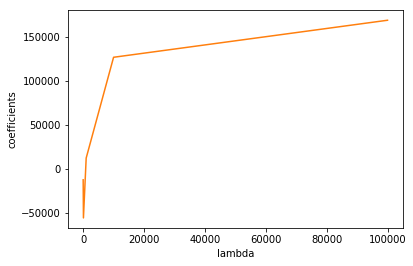

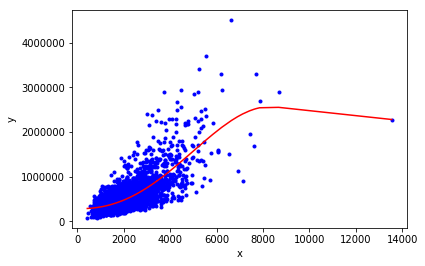

Train data
Lambda:  10
Weights:
 [[ 549223.95314427]
 [ -12206.69586015]
 [ 282900.69838726]
 [ 349301.28280423]
 [-488765.95120352]
 [-221768.8594125 ]
 [      0.        ]
 [ 135613.75740186]
 [ 122346.79964212]
 [  45657.45178905]
 [      0.        ]
 [      0.        ]
 [     -0.        ]
 [     -0.        ]
 [  -2081.09429538]
 [  -2671.99774167]
 [  -5569.71664207]]
RMSE:  250448.26039337518


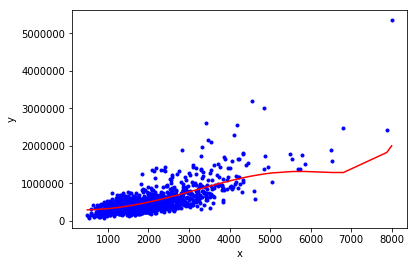

Validation data
Lambda:  100
Weights:
 [[  5.49223953e+05]
 [ -5.55090819e+04]
 [  4.64578630e+05]
 [  0.00000000e+00]
 [ -2.53699782e+05]
 [ -6.86007662e+04]
 [ -0.00000000e+00]
 [  0.00000000e+00]
 [  1.42331710e+04]
 [  4.94921069e+04]
 [  2.85499990e+04]
 [  1.55617948e+04]
 [  7.77671921e+03]
 [  3.57837067e+03]
 [  1.44647289e+03]
 [  4.34755788e+02]
 [  0.00000000e+00]]
RMSE:  267216.6701558379


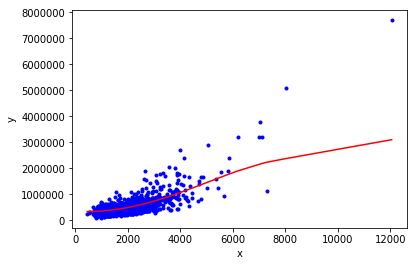

Test data
Lambda:  100
Weights:
 [[  5.49223953e+05]
 [ -5.55090819e+04]
 [  4.64578630e+05]
 [  0.00000000e+00]
 [ -2.53699782e+05]
 [ -6.86007662e+04]
 [ -0.00000000e+00]
 [  0.00000000e+00]
 [  1.42331710e+04]
 [  4.94921069e+04]
 [  2.85499990e+04]
 [  1.55617948e+04]
 [  7.77671921e+03]
 [  3.57837067e+03]
 [  1.44647289e+03]
 [  4.34755788e+02]
 [  0.00000000e+00]]
RMSE:  288083.558966543


In [19]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 16);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 16);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 16);
w_arr = [];
## Train
lamb = [10, 100, 1000, 10000, 100000];
a_min_train = np.ones(shape = (X_train.shape[1], 1));
cost_min_train = float('inf');
lamb_min_train = 0.0;
a_min_val = np.ones(shape = (X_val.shape[1], 1));
cost_min_val = float('inf');
lamb_min_val = 0.0;
w0_train = 0;
w0_val = 0;

for i in range(len(lamb)):
    clf = Lasso(alpha=lamb[i], max_iter=10000);
    clf.fit(X_train, y_train);
    
    a_temp = clf.coef_.reshape(len(clf.coef_), 1);
    a_temp1 = a_temp;
    a_temp1[0][0] = clf.intercept_[0];
    w_arr.append(a_temp1);
    
    cost_train = mean_squared_error(np.dot(X_train, a_temp1), y_train);
    cost_val = mean_squared_error(np.dot(X_val, a_temp1), y_val);

    if cost_train <= cost_min_train:
        a_min_train = a_temp;
        w0_train = clf.intercept_[0];
        cost_min_train = cost_train;
        lamb_min_train = lamb[i];

    if cost_val <= cost_min_val:
        a_min_val = a_temp;
        w0_val = clf.intercept_[0];
        cost_min_val = cost_val;
        lamb_min_val = lamb[i];
        
a_min_train[0][0] = w0_train;
a_min_val[0][0] = w0_val;

## Draw + print rmse
draw_w_coef(w_arr, lamb, True);
drawGraph(X_train, a_min_train, ma_train, df_train);
print('Train data');
print('Lambda: ', lamb_min_train);
print('Weights:\n', a_min_train);
print('RMSE: ', math.sqrt(cost_min_train));

drawGraph(X_val, a_min_val, ma_val, df_val);
print('Validation data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_min_val));

drawGraph(X_test, a_min_val, ma_test, df_test);
print('Test data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_func(a_min_val, X_test, y_test, m_test, lamb_min_val)));

### 3-1

In [20]:
df = pd.read_csv('ex2data3.csv.xls');
df = df.drop(columns=['Unnamed: 0']);

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [21]:
df_train, df_val, df_test = ryan_split_data(df, 20, 20);

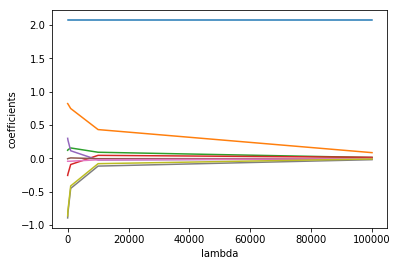

Train data
Lambda:  10
Weights:
 [[ 2.07239558]
 [ 0.82252723]
 [ 0.12191031]
 [-0.25437542]
 [ 0.30166611]
 [-0.0045586 ]
 [-0.04202783]
 [-0.89154792]
 [-0.86163509]]
RMSE:  0.72591648964912
Validation data
Lambda:  100
Weights:
 [[  2.07239558e+00]
 [  8.17362782e-01]
 [  1.30296678e-01]
 [ -2.32994634e-01]
 [  2.75278858e-01]
 [ -1.62521795e-03]
 [ -4.24942128e-02]
 [ -8.10558144e-01]
 [ -7.79745601e-01]]
RMSE:  0.72149767431444
Test data
Lambda:  100
Weights:
 [[  2.07239558e+00]
 [  8.17362782e-01]
 [  1.30296678e-01]
 [ -2.32994634e-01]
 [  2.75278858e-01]
 [ -1.62521795e-03]
 [ -4.24942128e-02]
 [ -8.10558144e-01]
 [ -7.79745601e-01]]
RMSE:  0.7116708648184855


In [22]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 0);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 0);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 0);
w_arr = [];

## Train
lamb = [10, 100, 1000, 10000, 100000];
a_min_train = np.ones(shape = (X_train.shape[1], 1));
cost_min_train = float('inf');
lamb_min_train = 0.0;
a_min_val = np.ones(shape = (X_val.shape[1], 1));
cost_min_val = float('inf');
lamb_min_val = 0.0;
w0_train = 0;
w0_val = 0;

for i in range(len(lamb)):
    clf = Ridge(alpha = lamb[i], max_iter=10000);
    clf.fit(X_train, y_train);
        
    a_temp = clf.coef_.T;
    a_temp1 = a_temp;
    a_temp1[0][0] = clf.intercept_[0];
    w_arr.append(a_temp1);
    
    cost_train = mean_squared_error(np.dot(X_train, a_temp1), y_train);
    cost_val = mean_squared_error(np.dot(X_val, a_temp1), y_val);
    
    if cost_train <= cost_min_train:
        a_min_train = clf.coef_.T;
        w0_train = clf.intercept_[0];
        cost_min_train = cost_train;
        lamb_min_train = lamb[i];

    if cost_val <= cost_min_val:
        a_min_val = clf.coef_.T;
        w0_val = clf.intercept_[0];
        cost_min_val = cost_val;
        lamb_min_val = lamb[i];
        
a_min_train[0][0] = w0_train;
a_min_val[0][0] = w0_val;

## Draw + print rmse
draw_w_coef(w_arr, lamb, False);
print('Train data');
print('Lambda: ', lamb_min_train);
print('Weights:\n', a_min_train);
print('RMSE: ', math.sqrt(cost_min_train));

print('Validation data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_min_val));

print('Test data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_func(a_min_val, X_test, y_test, m_test, None, None)));

### 3-2

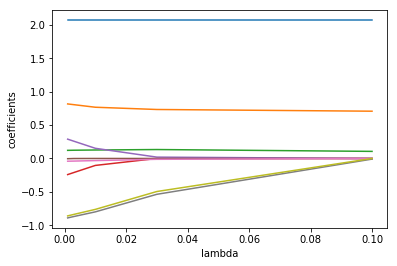

Train data
Lambda:  0.001
Weights:
 [[ 2.07239558]
 [ 0.81757942]
 [ 0.12175057]
 [-0.24150568]
 [ 0.28953161]
 [-0.00354518]
 [-0.04101007]
 [-0.89122229]
 [-0.86075984]]
RMSE:  0.725946050269648
Validation data
Lambda:  0.003
Weights:
 [[  2.07239558e+00]
 [  8.06691780e-01]
 [  1.23574091e-01]
 [ -2.10837390e-01]
 [  2.59058185e-01]
 [ -7.71493295e-04]
 [ -3.91103965e-02]
 [ -8.70361596e-01]
 [ -8.38587573e-01]]
RMSE:  0.7214966219845595
Test data
Lambda:  0.003
Weights:
 [[  2.07239558e+00]
 [  8.06691780e-01]
 [  1.23574091e-01]
 [ -2.10837390e-01]
 [  2.59058185e-01]
 [ -7.71493295e-04]
 [ -3.91103965e-02]
 [ -8.70361596e-01]
 [ -8.38587573e-01]]
RMSE:  0.7112114380930685


In [23]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 0);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 0);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 0);
w_arr = [];

## Train
lamb = [0.001, 0.003, 0.01, 0.03, 0.1];

a_min_train = np.ones(shape = (X_train.shape[1], 1));
cost_min_train = float('inf');
lamb_min_train = 0.0;
a_min_val = np.ones(shape = (X_val.shape[1], 1));
cost_min_val = float('inf');
lamb_min_val = 0.0;
w0_train = 0;
w0_val = 0;

for i in range(len(lamb)):
    clf = Lasso(alpha = lamb[i], max_iter=10000);
    clf.fit(X_train, y_train);
    a_temp = clf.coef_.reshape(len(clf.coef_), 1);
    a_temp1 = a_temp;
    a_temp1[0][0] = clf.intercept_[0];
    w_arr.append(a_temp1);
    
    cost_train = mean_squared_error(np.dot(X_train, a_temp1), y_train);
    cost_val = mean_squared_error(np.dot(X_val, a_temp1), y_val);
    
    if cost_train <= cost_min_train:
        a_min_train = a_temp;
        w0_train = clf.intercept_[0];
        cost_min_train = cost_train;
        lamb_min_train = lamb[i];

    if cost_val <= cost_min_val:
        a_min_val = a_temp;
        w0_val = clf.intercept_[0];
        cost_min_val = cost_val;
        lamb_min_val = lamb[i];
        
a_min_train[0][0] = w0_train;
a_min_val[0][0] = w0_val;

## Draw + print rmse
draw_w_coef(w_arr, lamb, False);
print('Train data');
print('Lambda: ', lamb_min_train);
print('Weights:\n', a_min_train);
print('RMSE: ', math.sqrt(cost_min_train));

print('Validation data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_min_val));

print('Test data');
print('Lambda: ', lamb_min_val);
print('Weights:\n', a_min_val);
print('RMSE: ', math.sqrt(cost_func(a_min_val, X_test, y_test, m_test, None, None)));

### 3-3

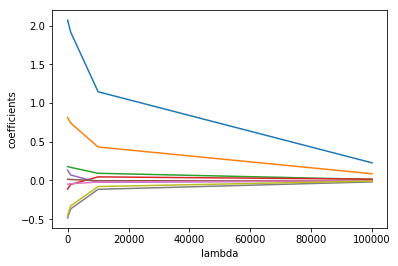

Train Data
Lambda:  10
Weight:
 [[ 2.07062554]
 [ 0.81252235]
 [ 0.17968297]
 [-0.11075953]
 [ 0.13299276]
 [ 0.01636806]
 [-0.04743369]
 [-0.48372611]
 [-0.44718459]]
RMSE:  0.745699
Validation Data
Lambda:  10
Weight:
 [[ 2.07062554]
 [ 0.81252235]
 [ 0.17968297]
 [-0.11075953]
 [ 0.13299276]
 [ 0.01636806]
 [-0.04743369]
 [-0.48372611]
 [-0.44718459]]
RMSE:  0.735118
Test Data
Lambda:  10
Weight:
 [[ 2.07062554]
 [ 0.81252235]
 [ 0.17968297]
 [-0.11075953]
 [ 0.13299276]
 [ 0.01636806]
 [-0.04743369]
 [-0.48372611]
 [-0.44718459]]
RMSE:  0.734897778129037


In [24]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 0);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 0);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 0);

## Train
lamb = [10, 100, 1000, 10000, 100000];
min_w_train, min_rmse_train, min_lamb_train, min_w_val, min_rmse_val, min_lamb_val, w_arr = ryan_tensorflow(lamb, X_train, y_train, X_val, y_val, 'ridge');

## Draw + print rmse

draw_w_coef(w_arr, lamb, False);
print('Train Data');
print('Lambda: ', min_lamb_train);
print('Weight:\n', min_w_train);
print('RMSE: ', min_rmse_train);

print('Validation Data');
print('Lambda: ', min_lamb_val);
print('Weight:\n', min_w_val);
print('RMSE: ', min_rmse_val);

print('Test Data');
print('Lambda: ', min_lamb_val);
print('Weight:\n', min_w_val);
print('RMSE: ', math.sqrt(mean_squared_error(np.dot(X_test, min_w_val), y_test)));


### 3-4

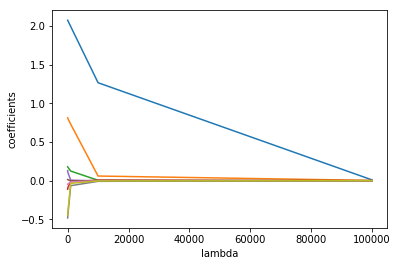

Train Data
Lambda:  10
Weight:
 [[ 2.0714891 ]
 [ 0.81228781]
 [ 0.17923468]
 [-0.10932127]
 [ 0.13118725]
 [ 0.01586482]
 [-0.04677479]
 [-0.48002896]
 [-0.44340363]]
RMSE:  0.746051
Validation Data
Lambda:  10
Weight:
 [[ 2.0714891 ]
 [ 0.81228781]
 [ 0.17923468]
 [-0.10932127]
 [ 0.13118725]
 [ 0.01586482]
 [-0.04677479]
 [-0.48002896]
 [-0.44340363]]
RMSE:  0.735591
Test Data
Lambda:  10
Weight:
 [[ 2.0714891 ]
 [ 0.81228781]
 [ 0.17923468]
 [-0.10932127]
 [ 0.13118725]
 [ 0.01586482]
 [-0.04677479]
 [-0.48002896]
 [-0.44340363]]
RMSE:  0.7353858024412959


In [25]:
## preprocess, init variables
X_train, y_train, m_train, ma_train = ryan_preprocess(df_train, 0);
X_val, y_val, m_val, ma_val = ryan_preprocess(df_val, 0);
X_test, y_test, m_test, ma_test = ryan_preprocess(df_test, 0);

## Train
lamb = [10, 100, 1000, 10000, 100000];
min_w_train, min_rmse_train, min_lamb_train, min_w_val, min_rmse_val, min_lamb_val, w_arr = ryan_tensorflow(lamb, X_train, y_train, X_val, y_val, 'lasso');

## Draw + print rmse
draw_w_coef(w_arr, lamb, False);
print('Train Data');
print('Lambda: ', min_lamb_train);
print('Weight:\n', min_w_train);
print('RMSE: ', min_rmse_train);

print('Validation Data');
print('Lambda: ', min_lamb_val);
print('Weight:\n', min_w_val);
print('RMSE: ', min_rmse_val);

print('Test Data');
print('Lambda: ', min_lamb_val);
print('Weight:\n', min_w_val);
print('RMSE: ', math.sqrt(mean_squared_error(np.dot(X_test, min_w_val), y_test)));